In [1]:
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

In [2]:
# raw data import
exp100=sc.read_10x_h5('../Data/sec_seq/GSE229042_filtered_feature_bc_matrix_100.h5',gex_only=False)
exp105=sc.read_10x_h5('../Data/sec_seq/GSE229042_filtered_feature_bc_matrix_105.h5',gex_only=False)
exp106=sc.read_10x_h5('../Data/sec_seq/GSE229042_filtered_feature_bc_matrix_106.h5',gex_only=False)

/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
exp100.var_names_make_unique()
exp105.var_names_make_unique()
exp106.var_names_make_unique()

## Pre-processing

In [4]:
# Exp100
sc.pp.filter_cells(exp100, min_genes=700) # Remove cells that have less than 700 genes expressed
# sc.pp.filter_genes(exp100, min_cells=3)
exp100.var['mt'] = exp100.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp100, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # QC

In [5]:
# Exp105
sc.pp.filter_cells(exp105, min_genes=500)
# sc.pp.filter_genes(exp100, min_cells=3)
exp105.var['mt'] = exp105.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp105, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [6]:
# Exp106
sc.pp.filter_cells(exp106, min_genes=1000)
# sc.pp.filter_genes(exp100, min_cells=3)
exp106.var['mt'] = exp106.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp106, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [7]:
exp100 = exp100[exp100.obs.total_counts < 50000, :]
exp100 = exp100[exp100.obs.pct_counts_mt < 10, :]
exp105 = exp105[exp105.obs.total_counts < 35000, :]
exp105 = exp105[exp105.obs.pct_counts_mt < 2.5, :]
exp106 = exp106[exp106.obs.total_counts < 50000, :]
exp106 = exp106[exp106.obs.pct_counts_mt < 5, :]

In [8]:
# filter cells with <2000 or <350 ADT barcodes
## (as noted by authors,#exp105 has other cell surface tag, IgG_ADT compromised, lower then exp100 and exp106)
exp100 = exp100[(exp100.obs_vector('IgG_ADT') <2000), :]
exp106 = exp106[(exp106.obs_vector('IgG_ADT') <2000), :]
exp105 = exp105[(exp105.obs_vector('IgG_ADT') <350), :]

In [9]:
# Concatenate raw counts from three donors into `data`
data = exp100.concatenate(exp105, exp106, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [19]:
# 1) Subset out your RNA object
rna = data[:, data.var["feature_types"] == "Gene Expression"].copy()

# 2) Then extract the ADT (antibody) feature from the full data
adt = data[:, data.var['feature_types'] == 'Antibody Capture'].copy()

if adt.shape[1] == 1:
    X = adt.X.toarray() if hasattr(adt.X, "toarray") else adt.X
    ab_counts = X.ravel()
    # now you can safely write into rna.obs
    rna.obs['IgG_ADT_counts'] = ab_counts
else:
    arr = adt.X.toarray() if hasattr(adt.X, "toarray") else np.asarray(adt.X)
    rna.obs['total_ADT_counts'] = arr.sum(axis=1)


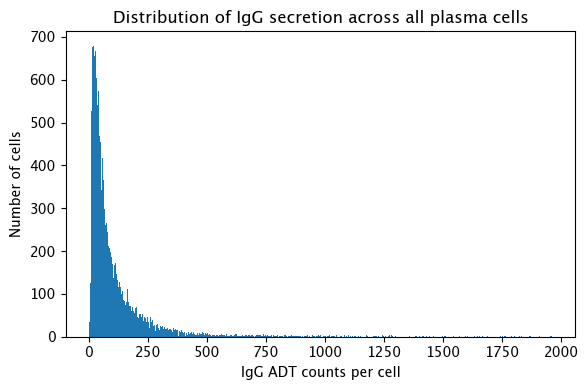

In [14]:
# pull out the counts
counts = rna.obs['IgG_ADT_counts']

# make the figure
plt.figure(figsize=(6,4))
plt.hist(counts, bins=500)
plt.xlabel('IgG ADT counts per cell')
plt.ylabel('Number of cells')
plt.title('Distribution of IgG secretion across all plasma cells')
plt.tight_layout()
plt.show()


## IgG Concentration and Productivity Analysis

This snippet calculates for each cell:
1. **IgG concentration** from ADT counts.
2. **Per-cell productivity** in mmol IgG per cell per hour.
3. **Productivity per gram dry cell weight** in mmol IgG per gDCW per hour.

**Parameters & assumptions:**
- Capture volume per cell: 11 pL  
- One UMI tag per IgG molecule  
- Avogadro’s number (N_A): 6.022×10²³ mol⁻¹  
- Incubation time: 30 min (0.5 h)  
- Average dry cell weight (w_cell): 300 pg (300×10⁻¹² g)  

In [18]:
# ─── Constants & parameters ────────────────────────────────────────────────
N_A            = 6.022e23      # molecules per mol
V_L            = 11e-12        # capture volume per cell, L (11 pL)
N_tags         = 1             # UMI tags per IgG molecule
incubation_min = 30            # incubation time, min
incubation_h   = incubation_min / 60  # incubation time, h
w_cell_g       = 300e-12       # dry cell weight, g (30 pg)

# ─── 1) Compute IgG concentration ──────────────────────────────────────────
counts     = rna.obs['IgG_ADT_counts'].values           # UMI counts per cell
molecules  = counts / N_tags                            # molecules per cell
conc_M     = molecules / (N_A * V_L)                   # mol/L

# Store concentration in AnnData
rna.obs['IgG_conc_M']  = conc_M
rna.obs['IgG_conc_pM'] = conc_M * 1e12

# ─── 2) Compute per-cell productivity (mmol/cell/h) ────────────────────────
moles_per_cell         = molecules / N_A                  # mol per cell
prod_mol_cell_h        = moles_per_cell / incubation_h   # mol/cell/h
prod_mmol_cell_h       = prod_mol_cell_h * 1e3           # mmol/cell/h

rna.obs['IgG_prod_mmol_per_cell_h'] = prod_mmol_cell_h

# ─── 3) Compute productivity per gDCW (mmol/gDCW/h) ───────────────────────
cells_per_gDCW         = 1.0 / w_cell_g                 # cells per gDCW
prod_mmol_gDCW_h       = prod_mmol_cell_h * cells_per_gDCW

rna.obs['IgG_prod_mmol_gDCW_h'] = prod_mmol_gDCW_h

# ─── 4) Summary ───────────────────────────────────────────────────────────
summary = pd.DataFrame({
    'ADT_counts':            counts,
    'conc_pM':               conc_M * 1e12,
    'mmol_cell_per_h':       prod_mmol_cell_h,
    'mmol_gDCW_per_h':       prod_mmol_gDCW_h
})
print(summary.describe())

         ADT_counts       conc_pM  mmol_cell_per_h  mmol_gDCW_per_h
count  14322.000000  14322.000000     1.432200e+04     1.432200e+04
mean     112.422707     16.971514     3.733733e-19     1.244578e-09
std      166.452469     25.127991     5.528147e-19     1.842723e-09
min        0.000000      0.000000     0.000000e+00     0.000000e+00
25%       31.000000      4.679811     1.029558e-19     3.431861e-10
50%       59.000000      8.906735     1.959482e-19     6.531606e-10
75%      126.000000     19.021164     4.184656e-19     1.394885e-09
max     1962.000000    296.186707     6.516107e-18     2.172036e-08


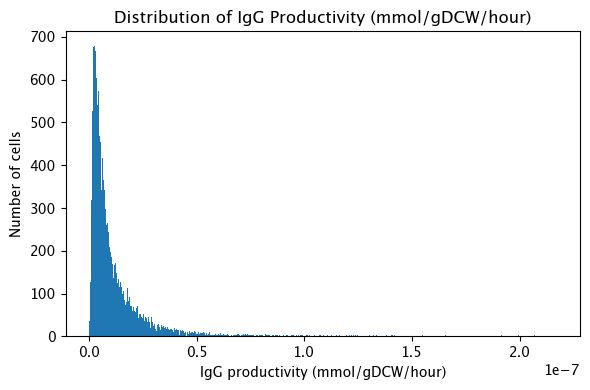

In [17]:
# —— Plot mmol/gDCW/hour —— #

prod_ug_h   = rna.obs['IgG_prod_mmol_gDCW_h'].values
plt.figure(figsize=(6,4))
plt.hist(prod_ug_h, bins=500)
plt.xlabel('IgG productivity (mmol/gDCW/hour)')
plt.ylabel('Number of cells')
plt.title('Distribution of IgG Productivity (mmol/gDCW/hour)')
plt.tight_layout()
plt.show()

## Gene Expression Analysis

In [ ]:
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import numpy as np

In [24]:
# Normalize each cell to the same total (e.g. 10 000 counts) then log1p
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

In [25]:
# If your rna.X is sparse:
expr = pd.DataFrame(
    rna.X.toarray(),
    index=rna.obs_names,
    columns=rna.var_names
)

# Your IgG counts (raw or log-transformed—pick consistently)
igg = rna.obs['IgG_ADT_counts']


In [33]:
expr['EBER1']

AAACCCAAGTACTGTC-1-0    0.0
AAACCCAAGTGAATAC-1-0    0.0
AAACCCACAGCTGTTA-1-0    0.0
AAACCCAGTCCACAGC-1-0    0.0
AAACCCATCACAGTGT-1-0    0.0
                       ... 
TTTGGTTTCGACTCCT-1-2    0.0
TTTGTTGAGGTACAAT-1-2    0.0
TTTGTTGAGTAACGAT-1-2    0.0
TTTGTTGCACGTTGGC-1-2    0.0
TTTGTTGGTCAACCAT-1-2    0.0
Name: EBER1, Length: 14322, dtype: float32

In [34]:
records = []
for gene in expr.columns:
    corr, pval = pearsonr(expr[gene], igg)
    records.append((gene, corr, pval))

corr_df = pd.DataFrame(records, columns=['gene','r','p'])

# 1) Drop any NaNs in the r or p columns
corr_df = corr_df.dropna(subset=['r','p'])

# 2) Adjust p-values and sort
corr_df = (
    corr_df
    .assign(p_adj=lambda df: smm.multipletests(df['p'], method='fdr_bh')[1])
    .sort_values('r', ascending=False)
)

# View top positive and negative correlations
print("Top positive correlations:\n", corr_df.head(10))
print("Top negative correlations:\n", corr_df.tail(10))


/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Top positive correlations:
             gene         r              p          p_adj
36559     MT-ND1  0.259192  1.449811e-218  3.484476e-214
36566     MT-ND3  0.231410  2.074933e-173  2.493447e-169
6788   MTRNR2L12  0.226552  4.232586e-166  3.390866e-162
36564    MT-ATP6  0.223745  5.924632e-162  3.559815e-158
24986      IGHG4  0.223632  8.678165e-162  4.171420e-158
36568     MT-ND4  0.221602  7.924654e-159  3.174352e-155
36565     MT-CO3  0.206883  3.056291e-138  9.181863e-135
36562     MT-CO2  0.204136  1.432233e-134  3.824699e-131
35058     SYNGR1  0.203326  1.692147e-133  4.066907e-130
36561     MT-CO1  0.198574  2.679929e-127  5.855401e-124
Top negative correlations:
            gene         r              p          p_adj
11762  HLA-DQA2 -0.119255   1.601310e-46   1.012786e-43
24990     IGHA1 -0.126248   5.753818e-52   4.321477e-49
11607     HLA-F -0.130389   2.430719e-55   1.947330e-52
21902     RPL41 -0.143655   6.649251e-67   6.146465e-64
25538       B2M -0.144389   1.409193e

In [57]:
corr_df[corr_df['gene']=='STX12']

,gene,r,p,p_adj
635,STX12,0.019846,0.017544,0.11035


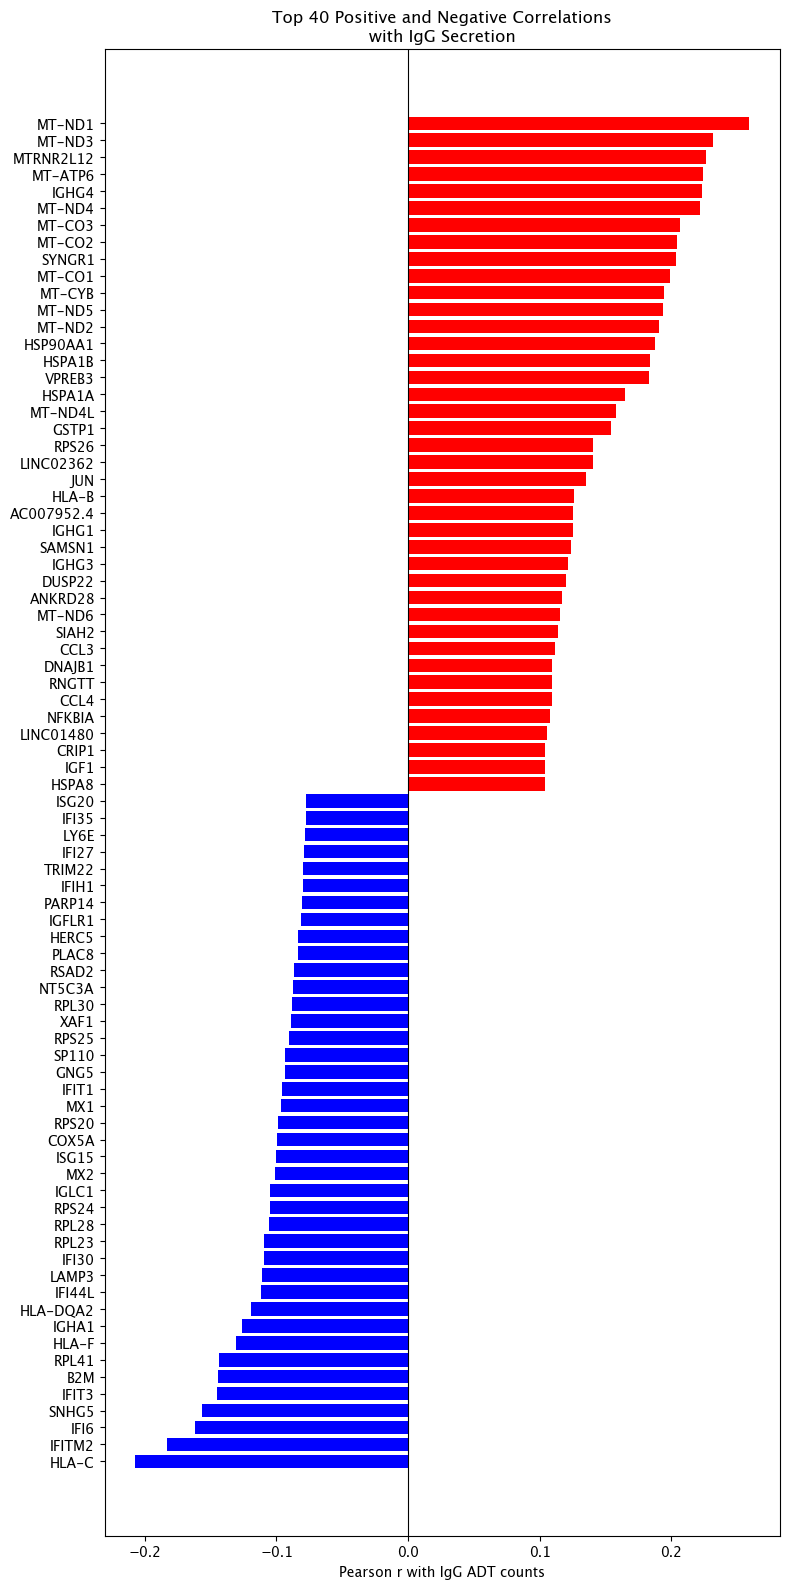

In [48]:
# how many of each to show
N = 40

# pick top N and bottom N
top = corr_df.head(N).copy()
bottom = corr_df.tail(N).copy()

# combine, but we want the negative correlations on top of the plot,
# so reverse the bottom slice
bottom = bottom.iloc[::-1]

plot_df = pd.concat([bottom, top]).sort_values(by='r')

# set up colors: negative in blue, positive in red
colors = ['blue' if x < 0 else 'red' for x in plot_df['r']]

plt.figure(figsize=(8, 16))
plt.barh(plot_df['gene'], plot_df['r'], color=colors)
plt.axvline(0, color='k', linewidth=0.8)               # vertical line at 0
plt.xlabel('Pearson r with IgG ADT counts')
plt.title(f'Top {N} Positive and Negative Correlations\nwith IgG Secretion')
plt.tight_layout()
plt.show()